# Оптимизация производственных расходов на металлургическом комбинате

**Цель проекта:**  
Построить модель, которая предскажет последнюю по времени температуру стали для каждой из партии, с целью уменьшения потребление электроэнергии на этапе обработки стали и снижения стоимости обслуживания и ремонта оборудования.  
При выборе модели необходимо добиться метрики MAE на тестовой выборке, которая не будет превышать 6.8

**Описание процедуры легирования стали (десульфурация):**  
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн.  
Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами.  
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ.
Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

## Исследовательский анализ данных

### Предварительное изучение общей информации

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler
from pyod.models.knn import KNN
from sklearn.decomposition import PCA

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, make_scorer

!pip install phik
from phik.report import plot_correlation_matrix
from phik import report
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy

import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 170723

     |████████████████████████████████| 679 kB 1.1 MB/s eta 0:00:01


In [2]:
def df_info(df):
    display(df.sample(5))
    display(df.info())
    display(df.describe(include='all'))
    df.hist(figsize=(30, 15));

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
6922,1505,2019-06-28 23:40:40,2019-06-28 23:43:37,0.817462,0.618428
589,128,2019-05-08 09:57:01,2019-05-08 09:58:01,0.556910,0.361413
4496,968,2019-06-09 23:28:27,2019-06-09 23:32:01,1.013087,0.820143
8104,1757,2019-07-07 20:48:15,2019-07-07 20:51:20,0.414600,0.304068
12005,2612,2019-08-14 20:25:51,2019-08-14 20:30:23,0.633815,0.540184


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
unique,NaN,14876,14876,NaN,NaN
top,NaN,2019-06-18 20:04:23,2019-07-08 23:48:48,NaN,NaN
freq,NaN,1,1,NaN,NaN
mean,1615.220422,NaN,NaN,0.662752,0.438986
std,934.571502,NaN,NaN,0.258885,5.873485
min,1.000000,NaN,NaN,0.223120,-715.479924
25%,806.000000,NaN,NaN,0.467115,0.337175
50%,1617.000000,NaN,NaN,0.599587,0.441639
75%,2429.000000,NaN,NaN,0.830070,0.608201


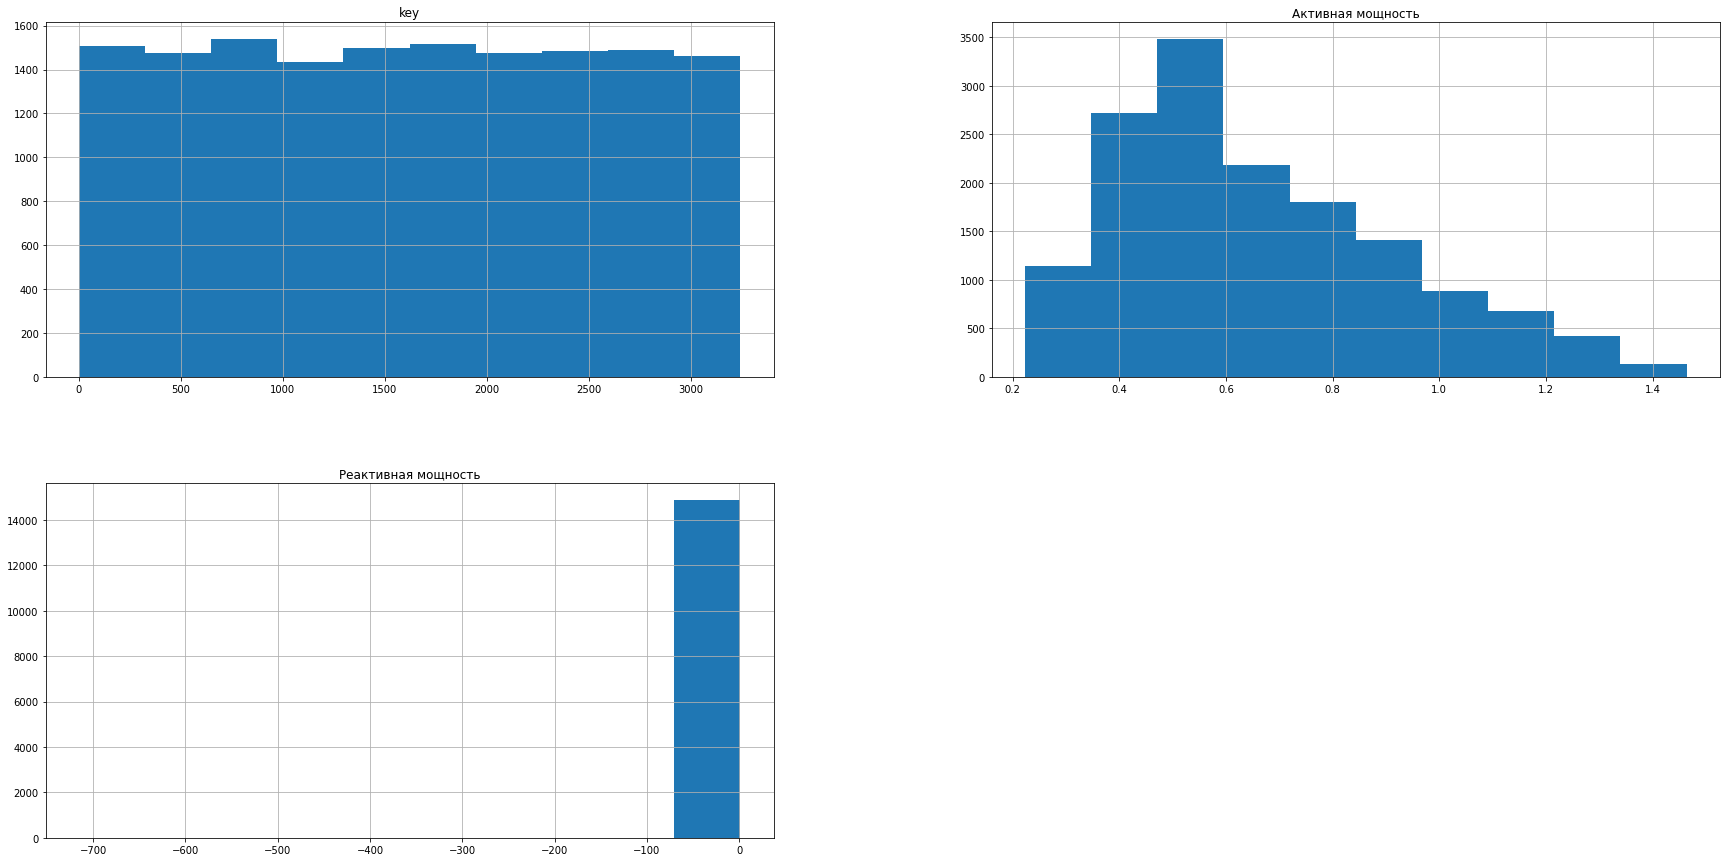

In [3]:
arc = pd.read_csv('/datasets/data_arc_new.csv')
df_info(arc)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2499,2591,32.0,NaN,NaN,NaN,NaN,96.0,NaN,NaN,NaN,NaN,NaN,108.0,NaN,228.0,108.0
127,140,27.0,NaN,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209.0,202.0
43,46,NaN,NaN,NaN,NaN,NaN,70.0,NaN,NaN,NaN,NaN,NaN,204.0,NaN,401.0,204.0
2517,2613,NaN,NaN,48.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266.0,NaN,200.0,210.0
2565,2663,NaN,NaN,96.0,NaN,NaN,80.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,118.0,206.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


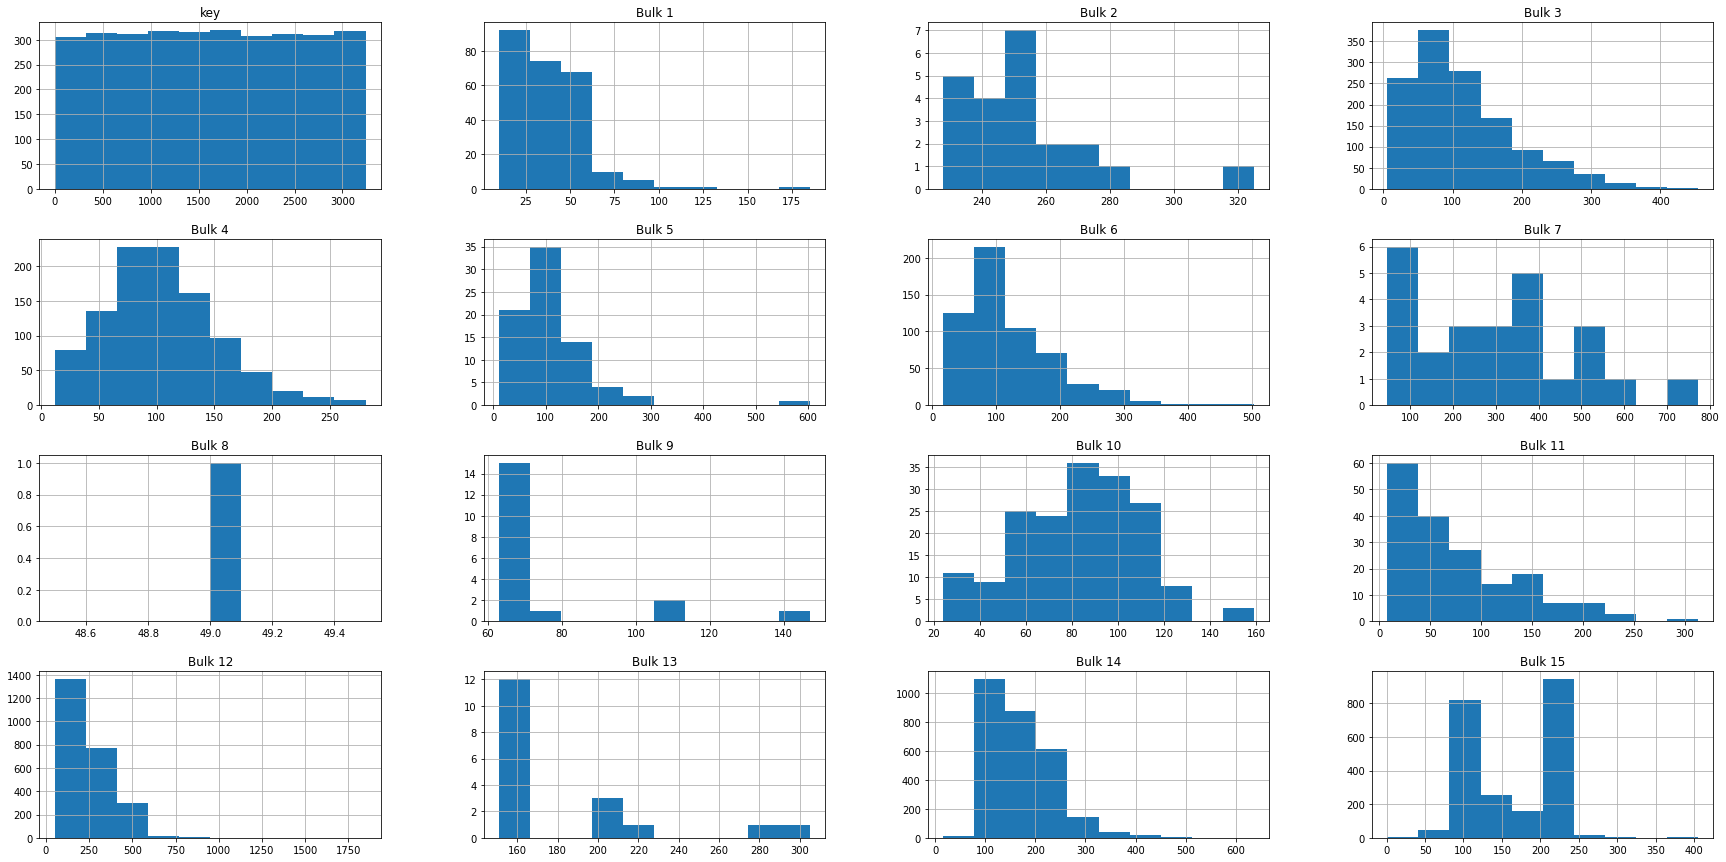

In [4]:
bulk = pd.read_csv('/datasets/data_bulk_new.csv')
df_info(bulk)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2364,2490,126.060486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1423,1495,131.180390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2924,3083,66.306244,121.213043,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920,2015,111.165598,15.110160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2995,3154,80.240159,90.359352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


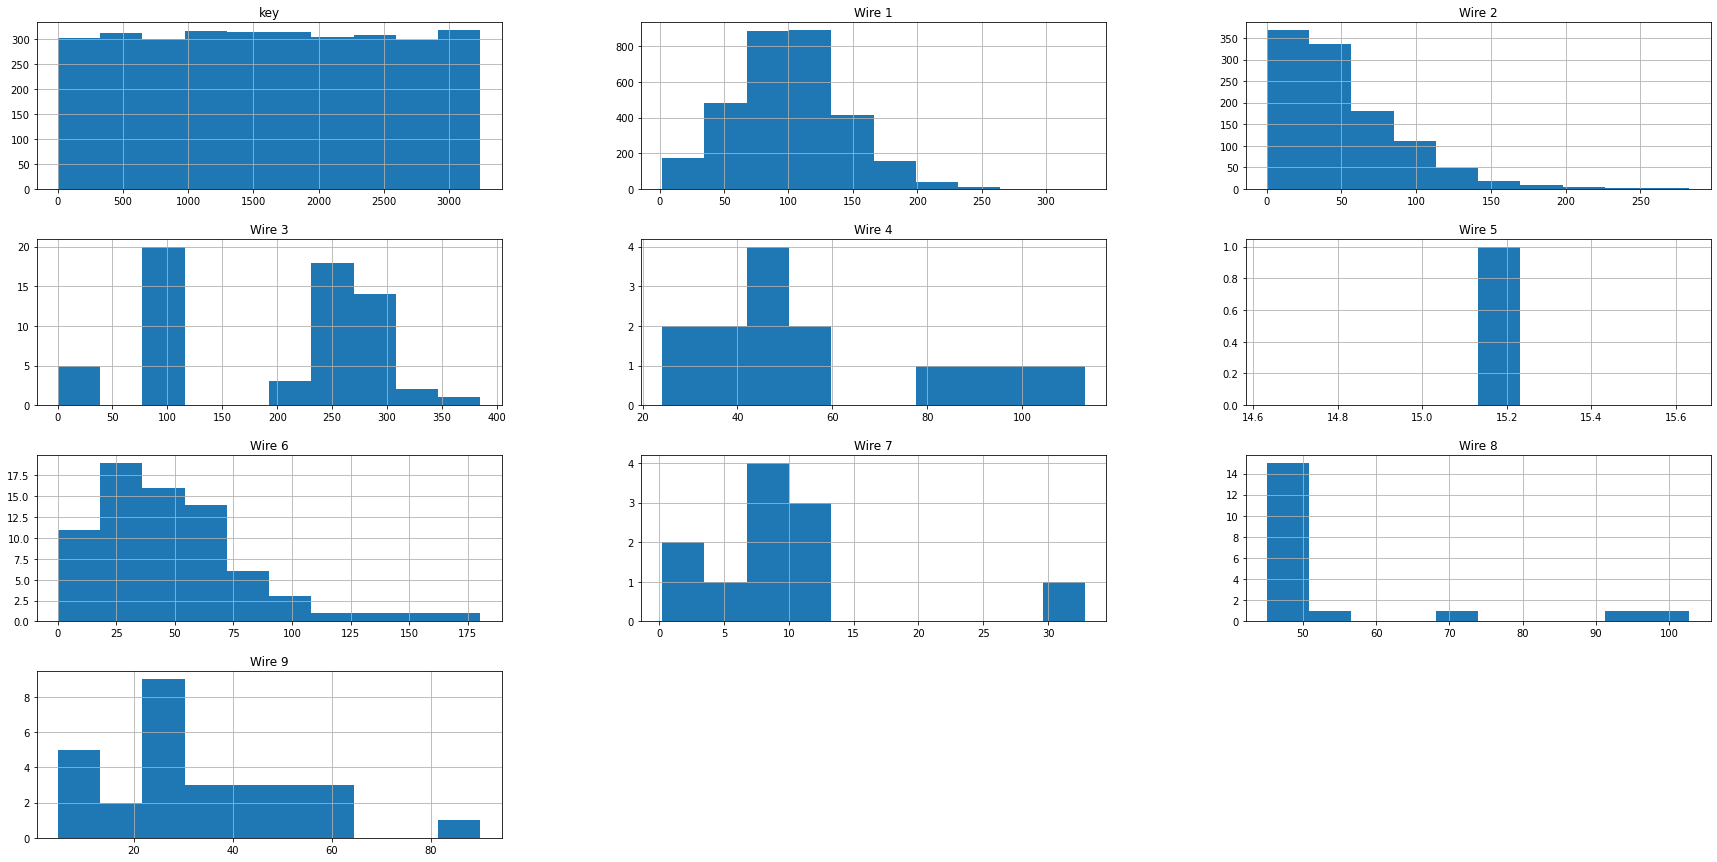

In [5]:
wire = pd.read_csv('/datasets/data_wire_new.csv')
df_info(wire)

,key,Газ 1
1911,1914,5.229656
1609,1612,9.714280
3076,3079,14.324667
3078,3081,7.776848
1088,1091,6.740895


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


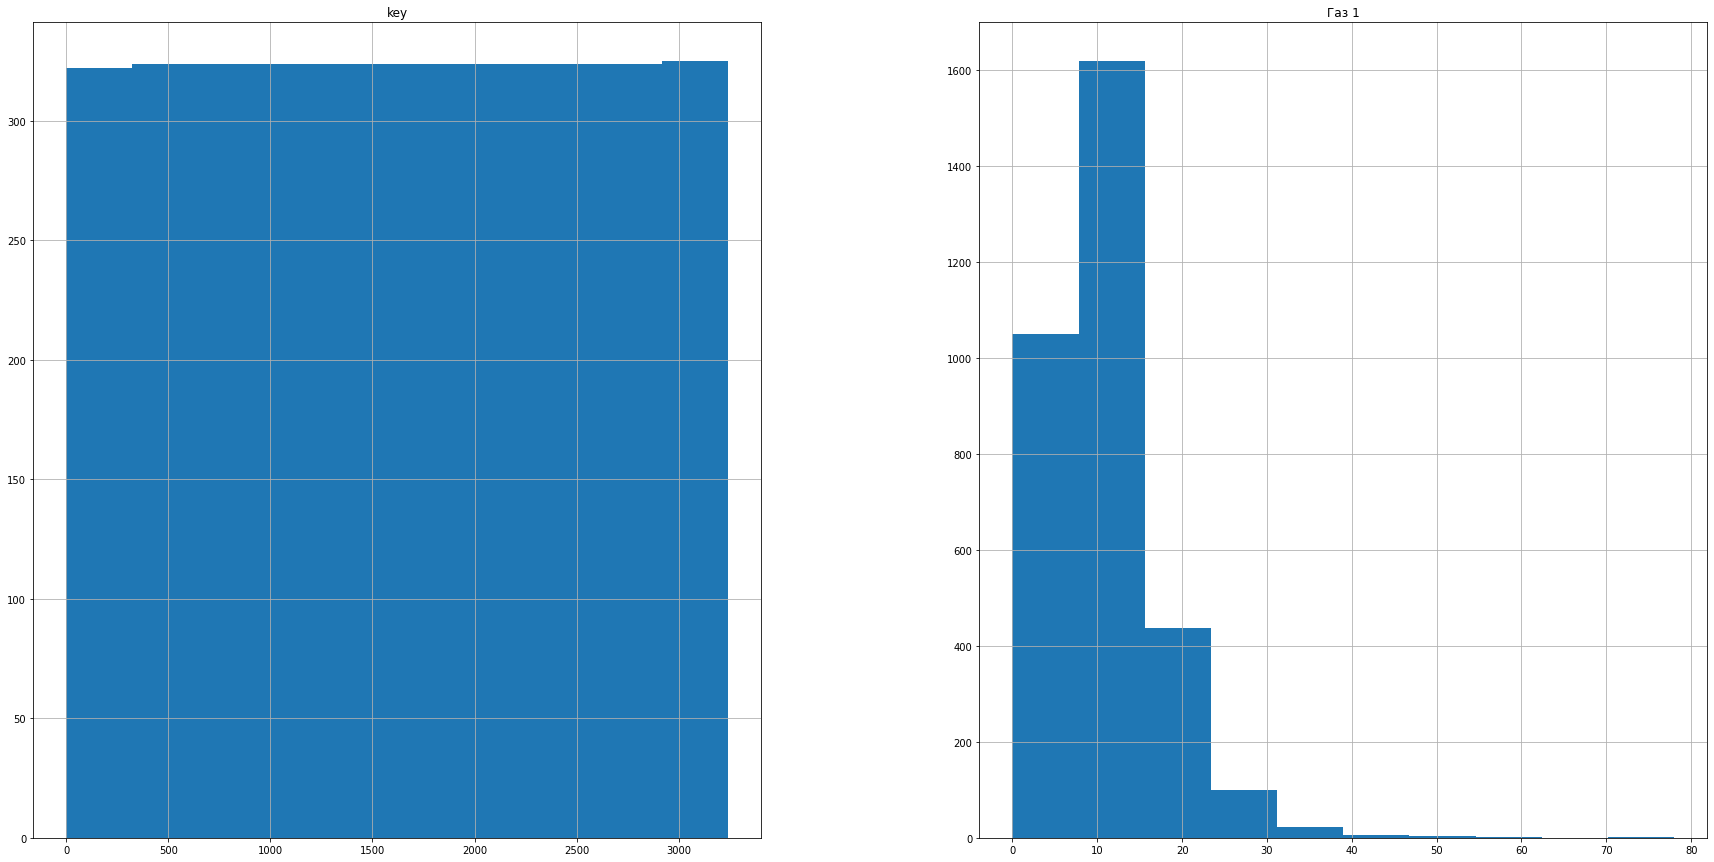

In [6]:
gas = pd.read_csv('/datasets/data_gas_new.csv')
df_info(gas)

,key,Время замера,Температура
4458,796,2019-06-03 12:00:11,1670.0
12974,2321,2019-08-03 23:24:22,1566.0
4719,840,2019-06-05 05:04:26,1580.0
3273,586,2019-05-25 17:40:51,1594.0
7296,1307,2019-06-21 18:27:41,1587.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

,key,Время замера,Температура
count,18092.000000,18092,14665.000000
unique,NaN,18092,NaN
top,NaN,2019-06-10 16:18:04,NaN
freq,NaN,1,NaN
mean,1616.460977,NaN,1590.722741
std,934.641385,NaN,20.394381
min,1.000000,NaN,1191.000000
25%,807.750000,NaN,1580.000000
50%,1618.000000,NaN,1590.000000
75%,2429.000000,NaN,1599.000000


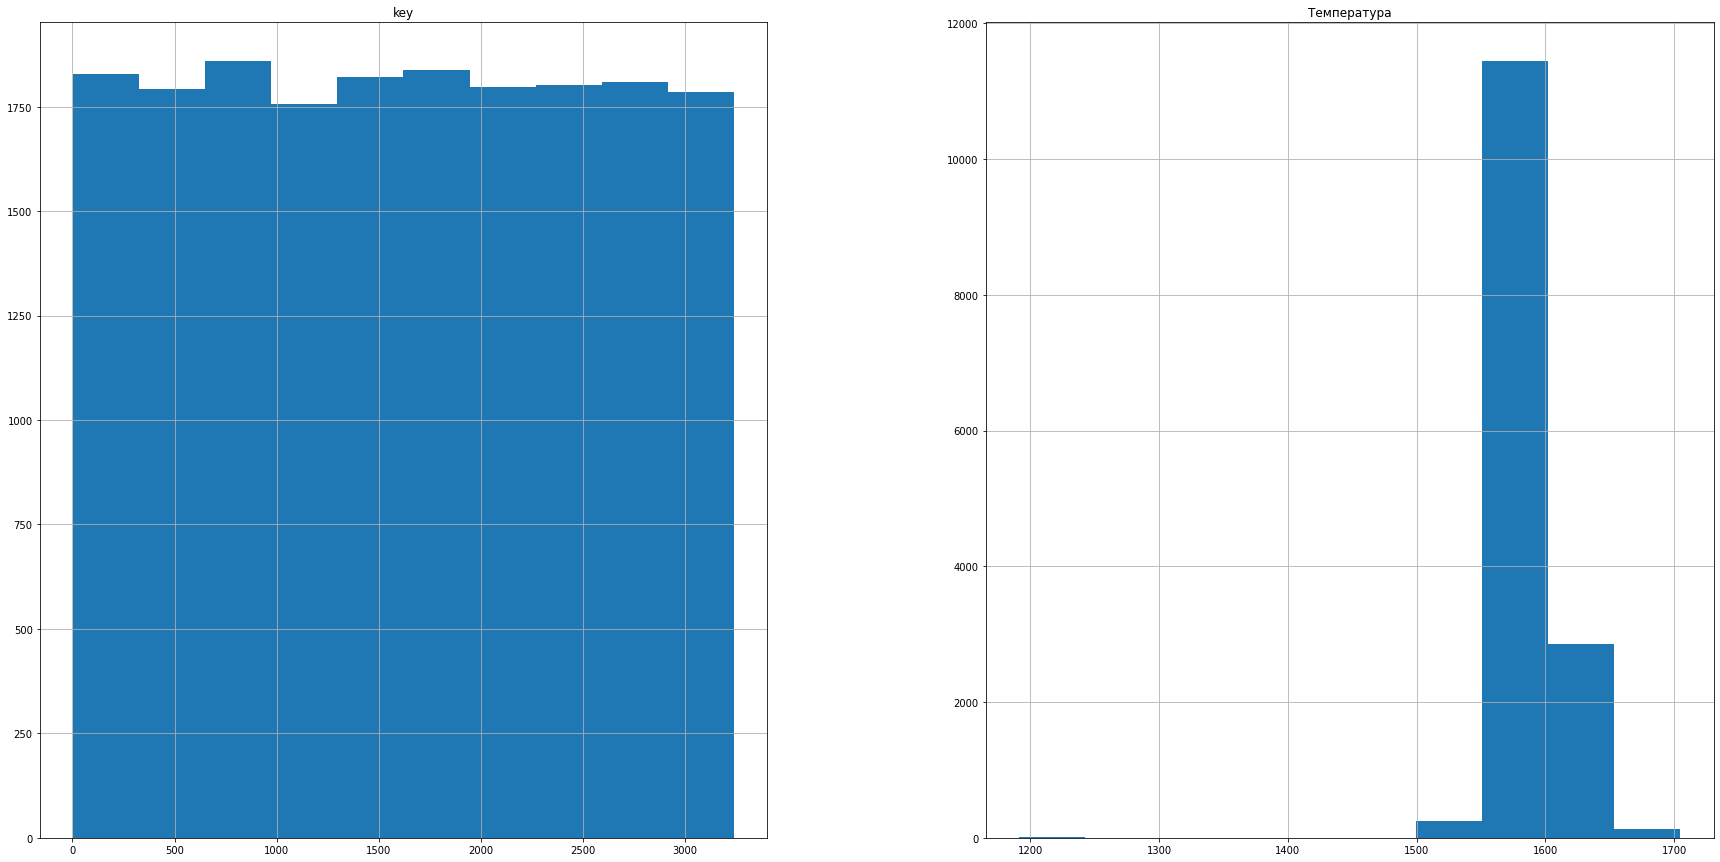

In [7]:
temp = pd.read_csv('/datasets/data_temp_new.csv')
df_info(temp)

In [8]:
bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
bulk_time.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [9]:
wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
wire_time.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Полученные результаты предварительного изучения общей информации:**
1. Данные об электродах - "data_arc_new":  
    пропусков нет  
    ввести 3 новых показателя:  
    $$ВремяНагрева=КонецНагреваДугой-НачалоНагреваДугой$$
    $$ПолнуюМощность=\sqrt(АктивнаяМощность^{2}+РеактивнаяМощность^{2})$$
    $$Работа=ПолнуюМощность*ВремяНагрева$$
    избавиться от выбросов в колонке "Реактивная мощность" (отрицательные показатели реактивной мощности)
2. Данные о подаче сыпучих материалов (объём) - "data_bulk_new":  
    пропуски заполняем 0 (они связаны с тем, что в разные партии добавляли разные сыпучие материалы)
3. Данные о проволочных материалах (объём) - "data_wire_new":  
    пропуски заполняем 0 (они связаны с тем, что в разные партии добавляли разные сыпучие материалы)
4. Данные о продувке сплава газом - "data_gas_new":  
    пропусков нет  
    избавиться от выбросов в колонке "Газ 1" (показатели газа выше 35)
5. Данные о результатах измерения температуры - "data_temp_new":  
    удалить данные с пропусками в колонке Температура (так как температура основная цель исследования, считаем, что отсутствие данных это шум, от которого необходимо избавиться)  
    избавиться от выбросов в колонке Температура (показатели температуры ниже 1500)  
    ввести 2 новых показателя "Температура первого замера" и "Температура последнего замера"  
    ввести новый показатель "Количество итераций", отражающий операции по добавкам легирующих материалов, нагрева, продувки и замера температуры в каждой партии (изучить влияние количества итераций на целевой признак)  
    удалить неинформативные для обучения модели признаки - колонку "Время замера", так как время замера никак не влияет на технологический процесс процедуры легирования стали
6. Данные о подаче сыпучих материалов (время)/"data_bulk_time" и данные о проволочных материалах (время)/"data_wire_time":  
    удалить неинформативные для обучения модели признаки, так как время подачи никак не влияет на технологический процесс процедуры легирования стали при соблюдении технологии подачи легирующих материалов

В следующем разделе проведем предобработку данных, в соответствии с полученными результатами предварительного изучения общей информации

### Предобработка данных

Предобработка данных об электродах - "data_arc_new"

In [10]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

In [11]:
arc['heating_time'] = (arc['Конец нагрева дугой']-arc['Начало нагрева дугой']).dt.total_seconds()
arc['full_power'] = (arc['Активная мощность']**2+arc['Реактивная мощность']**2)**0.5
arc['work'] = arc['heating_time']*arc['full_power']

In [12]:
arc[arc['Реактивная мощность']<=0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heating_time,full_power,work
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924,109.0,715.480272,77987.349613


In [13]:
arc = arc.drop(arc[arc.key==2116].index)
arc = arc.drop(arc.columns[[1,2,4]], axis = 1)

In [14]:
arc = arc.groupby('key').sum()
arc = arc.rename(columns = {'Активная мощность': 'active_power'})

In [15]:
arc.head()

,active_power,heating_time,full_power,work
key,,,,
1,3.036730,1098.0,3.718736,770.282114
2,2.139408,811.0,2.588349,481.760005
3,4.063641,655.0,5.019223,722.837668
4,2.706489,741.0,3.400038,683.455597
5,2.252950,869.0,2.816980,512.169934


Предобработка данных о подаче сыпучих материалов - "data_bulk_new" и данных о подаче проволочных материалах - "data_wire_new"

In [16]:
(bulk.drop(columns=['key']).count()/len(bulk)*100).round().sort_values(ascending=False)

Bulk 14    90.0
Bulk 12    78.0
Bulk 15    72.0
Bulk 3     41.0
Bulk 4     32.0
Bulk 6     18.0
Bulk 1      8.0
Bulk 10     6.0
Bulk 11     6.0
Bulk 5      2.0
Bulk 2      1.0
Bulk 7      1.0
Bulk 9      1.0
Bulk 13     1.0
Bulk 8      0.0
dtype: float64

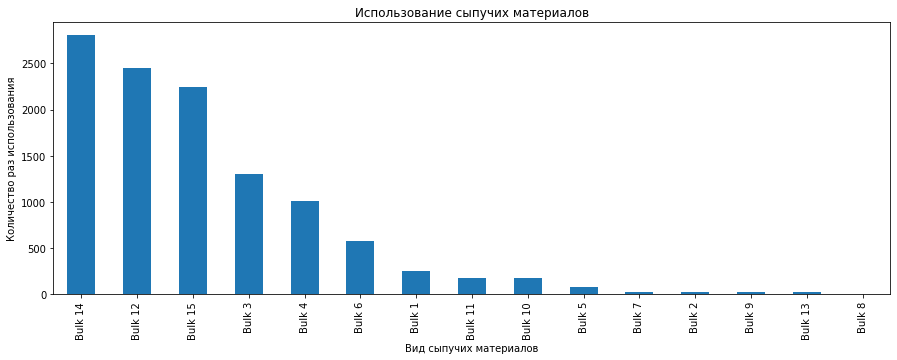

In [17]:
bulk.drop(columns=['key']).count().sort_values(ascending=False).plot(kind = 'bar', figsize = (15,5))
plt.ylabel('Количество раз использования')
plt.xlabel('Вид сыпучих материалов')
plt.title('Использование сыпучих материалов')
plt.show()

In [18]:
bulk = bulk.groupby('key').sum()
bulk.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [19]:
(wire.drop(columns=['key']).count()/len(wire)*100).round().sort_values(ascending=False)

Wire 1    99.0
Wire 2    35.0
Wire 3     2.0
Wire 6     2.0
Wire 8     1.0
Wire 9     1.0
Wire 4     0.0
Wire 5     0.0
Wire 7     0.0
dtype: float64

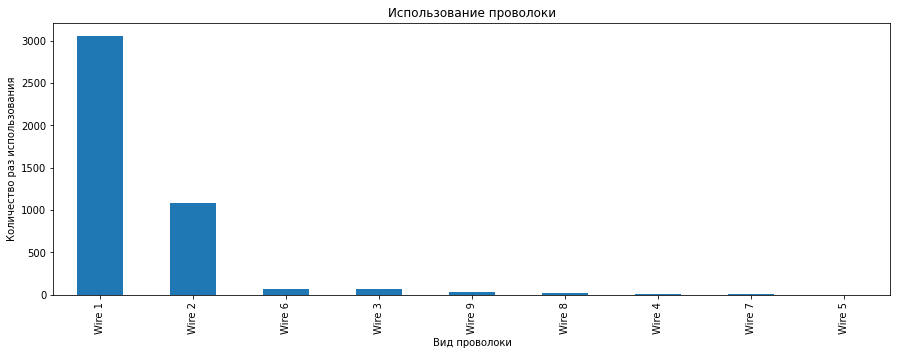

In [20]:
wire.drop(columns=['key']).count().sort_values(ascending=False).plot(kind = 'bar', figsize = (15,5))
plt.ylabel('Количество раз использования')
plt.xlabel('Вид проволоки')
plt.title('Использование проволоки')
plt.show()

In [21]:
wire = wire.groupby('key').sum()
wire.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Предобработка данных о продувке сплава газом - "data_gas_new"

In [22]:
gas = gas.groupby('key').sum()
gas = gas.rename(columns = {'Газ 1': 'gas'})
gas.head()

,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


Предобработка данных о результатах измерения температуры - "data_temp_new"

In [23]:
temp['Время замера'] = pd.to_datetime(temp['Время замера'], format='%Y-%m-%dT%H:%M:%S')
temp = temp.rename(columns = {'Температура': 'temperature',  'Время замера': 'time'})

In [24]:
count_temp = temp.groupby('key').agg({'temperature': 'count'})
count_temp = count_temp.rename(columns = {'temperature': 'iteration'})
count_temp.head()

,iteration
key,
1,6
2,5
3,6
4,5
5,5


In [25]:
time_first = temp.groupby('key').time.min()
temp_first = temp.query('time in @time_first').set_index('key')
temp_first = temp_first.rename(columns = {'temperature': 'temp_first'})
temp_first = temp_first.drop(temp_first[temp_first.temp_first<1400].index)
temp_first.head()

,time,temp_first
key,,
1,2019-05-03 11:02:04,1571.0
2,2019-05-03 11:34:04,1581.0
3,2019-05-03 12:06:44,1596.0
4,2019-05-03 12:39:27,1601.0
5,2019-05-03 13:11:03,1576.0


In [26]:
time_last = temp.groupby('key').time.max()
temp_last = temp.query('time in @time_last').set_index('key')
temp_last = temp_last.rename(columns = {'temperature': 'temp_last'})
temp_last = temp_last.drop(temp_last.columns[[0]], axis = 1)
temp_last = temp_last.dropna()
temp_last.tail()

,temp_last
key,
2495,1591.0
2496,1591.0
2497,1589.0
2498,1594.0
2499,1603.0


In [27]:
temp_last.describe()

,temp_last
count,2477.000000
mean,1595.334275
std,16.019339
min,1541.000000
25%,1587.000000
50%,1593.000000
75%,1599.000000
max,1700.000000


In [28]:
temp_last

,temp_last
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0
...,...
2495,1591.0
2496,1591.0
2497,1589.0


Объединение таблиц

In [29]:
df_final = (temp_last.merge(arc, on='key', how='inner')
                    .merge(bulk, on='key', how='inner')
                    .merge(wire, on='key', how='inner')
                    .merge(gas, on='key', how='inner')
                    .merge(count_temp, on='key', how='inner')
                    .merge(temp_first.temp_first, on='key', how='inner'))

In [30]:
df_final['efficiency'] = df_final['full_power']/df_final['iteration']

In [31]:
df_final.shape

(2324, 33)

**Полученные результаты:**  
По результатам проведенной предобработки данных была получена сводная таблица, к которой добавили 7 новых производных признаков, которые оценим в следующем разделе по статистическому анализу данных  
Дополнительно был введен показатель "Эффективность", показывающая насколько эффективно используется электроэнергия на каждой итерации  
$$Эффективность=Работа/КоличествоИтераций$$  
При анализе данных о подаче сыпучих и проволочных материалов, учитывая уровень существенности (<2%), при обучении моделей можно исключить следующие признаки:  
Bulk 2,Bulk 7,Bulk 9,Bulk 13,Bulk 8  
Wire 8,Wire 9,Wire 4,Wire 5,Wire 7  
При объединении таблиц количество объектов с целевым признаком temp_last (последней по времени температуры) уменьшилось с 2477 до 2324 на 6%, которые потеряли при объединении из-за того, что по признакам с нулевыми значениями ключи не заводили

### Статистический анализ данных

Так как все данные в полученной сводной таблице числовые, то будут использоваться соответствующие наиболее эффективные методы статистического анализа  
И для начала построим матрицу корреляций для визуального отображения наличия или отсутствия корреляции между данными

interval columns not set, guessing: ['temp_last', 'active_power', 'heating_time', 'full_power', 'work', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'gas', 'iteration', 'temp_first', 'efficiency']


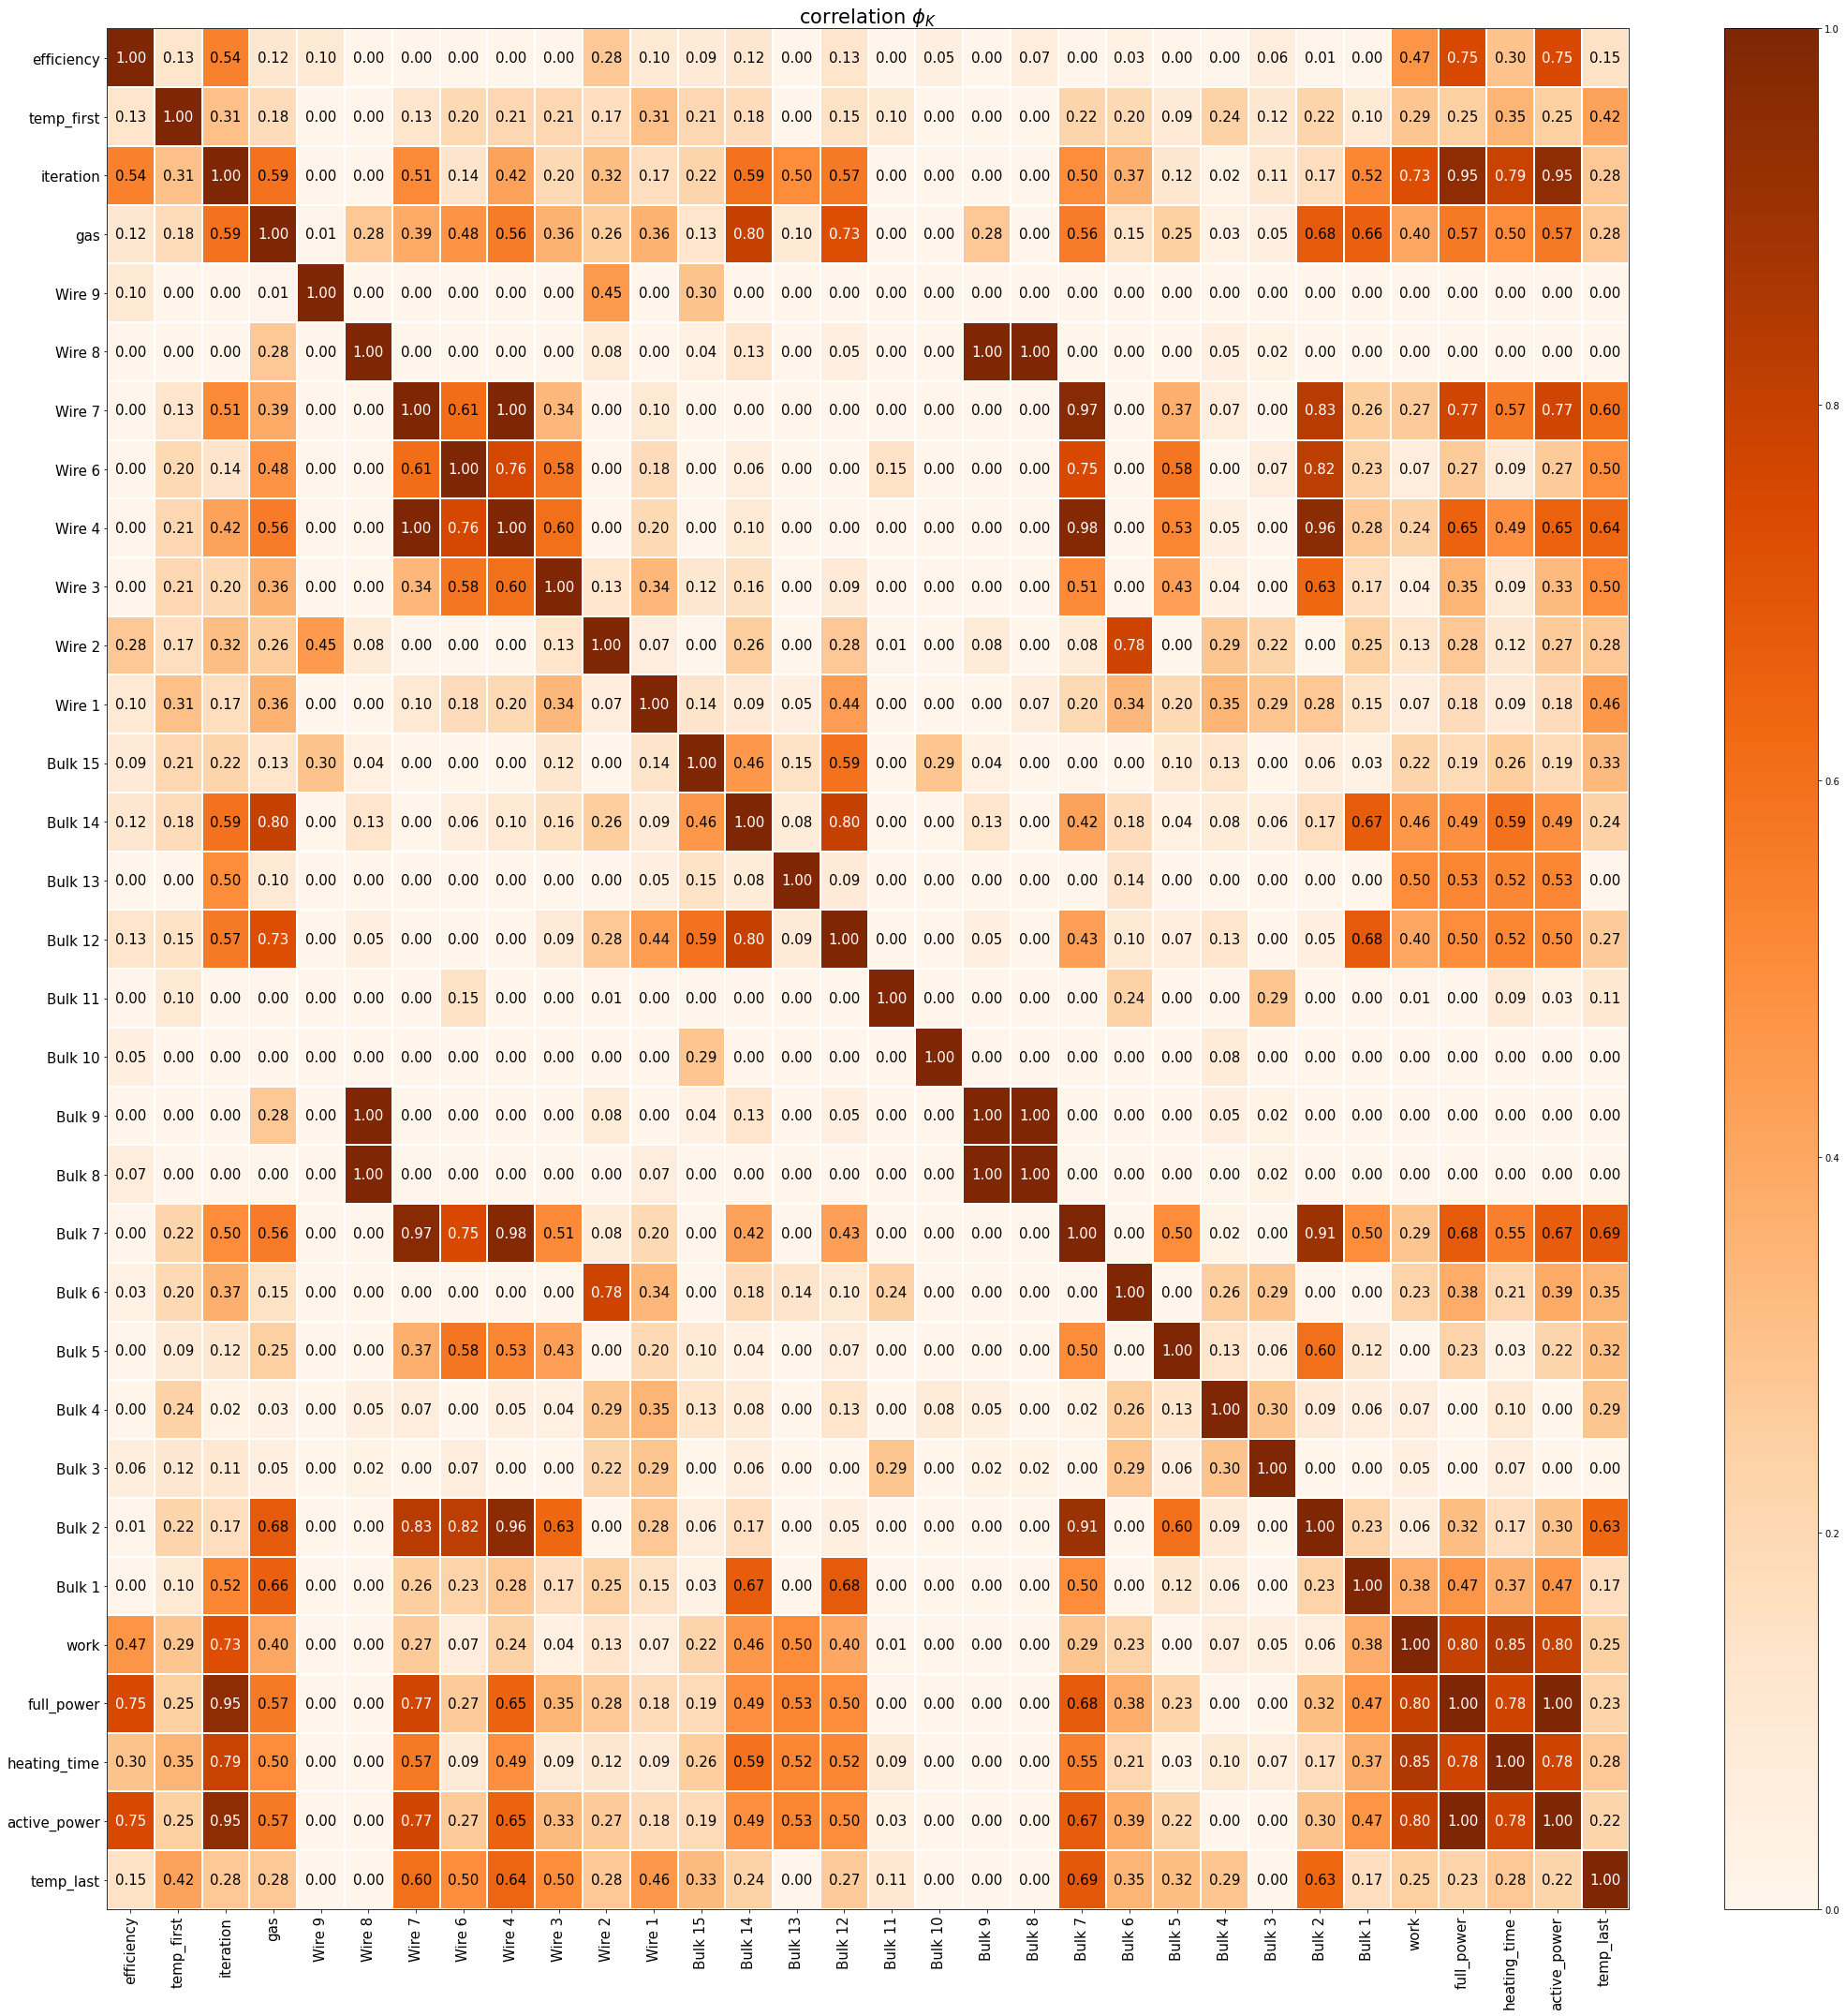

In [32]:
phik_overview = df_final.phik_matrix().round(2)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Oranges", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(30, 30))

Признаки "Работа/work" и "Время нагрева/heating_time" мультиколлинеарны, то есть имеют сильную линейную корреляцию между собой.
Докажем это статистическим тестом, но для того чтобы определить какой статистический тест использовать необходимо определить нормально ли распределены данные  
Для этого используем график qq_plot

In [33]:
def qq_plot(x, title):
    m = x.mean()
    std = x.std()
    x = (x - m)/std

    sm.qqplot(x, line ='45')
    plt.title(title)
    plt.show()

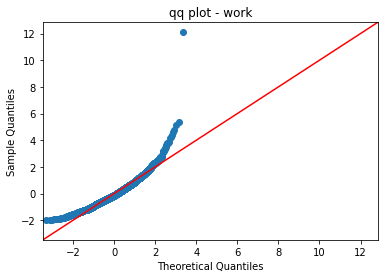

In [34]:
qq_plot(df_final.work, 'qq plot - work')

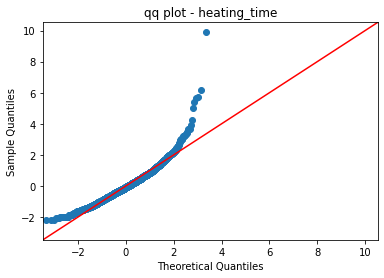

In [35]:
qq_plot(df_final.heating_time, 'qq plot - heating_time')

Так как данные признаков "Работа/work" и "Время нагрева/heating_time" распределены ненормально, то для статистического теста числовых признаков не можем использовать корреляционный тест Пирсона, но можем использовать корреляционный тест Спирмена  


H0: **work** и **heating_time** не мультиколлинеарны  
H1: **work** и **heating_time** мультиколлинеарны

In [36]:
stat, p = scipy.stats.spearmanr(df_final.work, df_final.heating_time)
print(f'stat={stat:.3f}, p={p:.6f}')
if p > 0.05:
    print('Нет досточных оснований, чтобы отклонить H0')
else:
    print('Есть достаточно оснований, чтобы отклонить H0, приманимаем H1.')

stat=0.884, p=0.000000
Есть достаточно оснований, чтобы отклонить H0, приманимаем H1.


Так как признак "Работа/work" оказывает меньшее влияние (0,25) на целевой признак "Температура последнего замера/temp_last" чем "Время нагрева/heating_time" (0,28), то из финальной таблицы удаляем признак "Работа/work"

Так же удалим все признаки, у которых корреляция с целевым признаком равна нулю

In [37]:
df_final = df_final.drop(['work','Bulk 13','Bulk 10','Bulk 9','Bulk 8','Bulk 3',
                          'Wire 9','Wire 8','Wire 7','Wire 5'], axis = 1)

interval columns not set, guessing: ['temp_last', 'active_power', 'heating_time', 'full_power', 'Bulk 1', 'Bulk 2', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 11', 'Bulk 12', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6', 'gas', 'iteration', 'temp_first', 'efficiency']


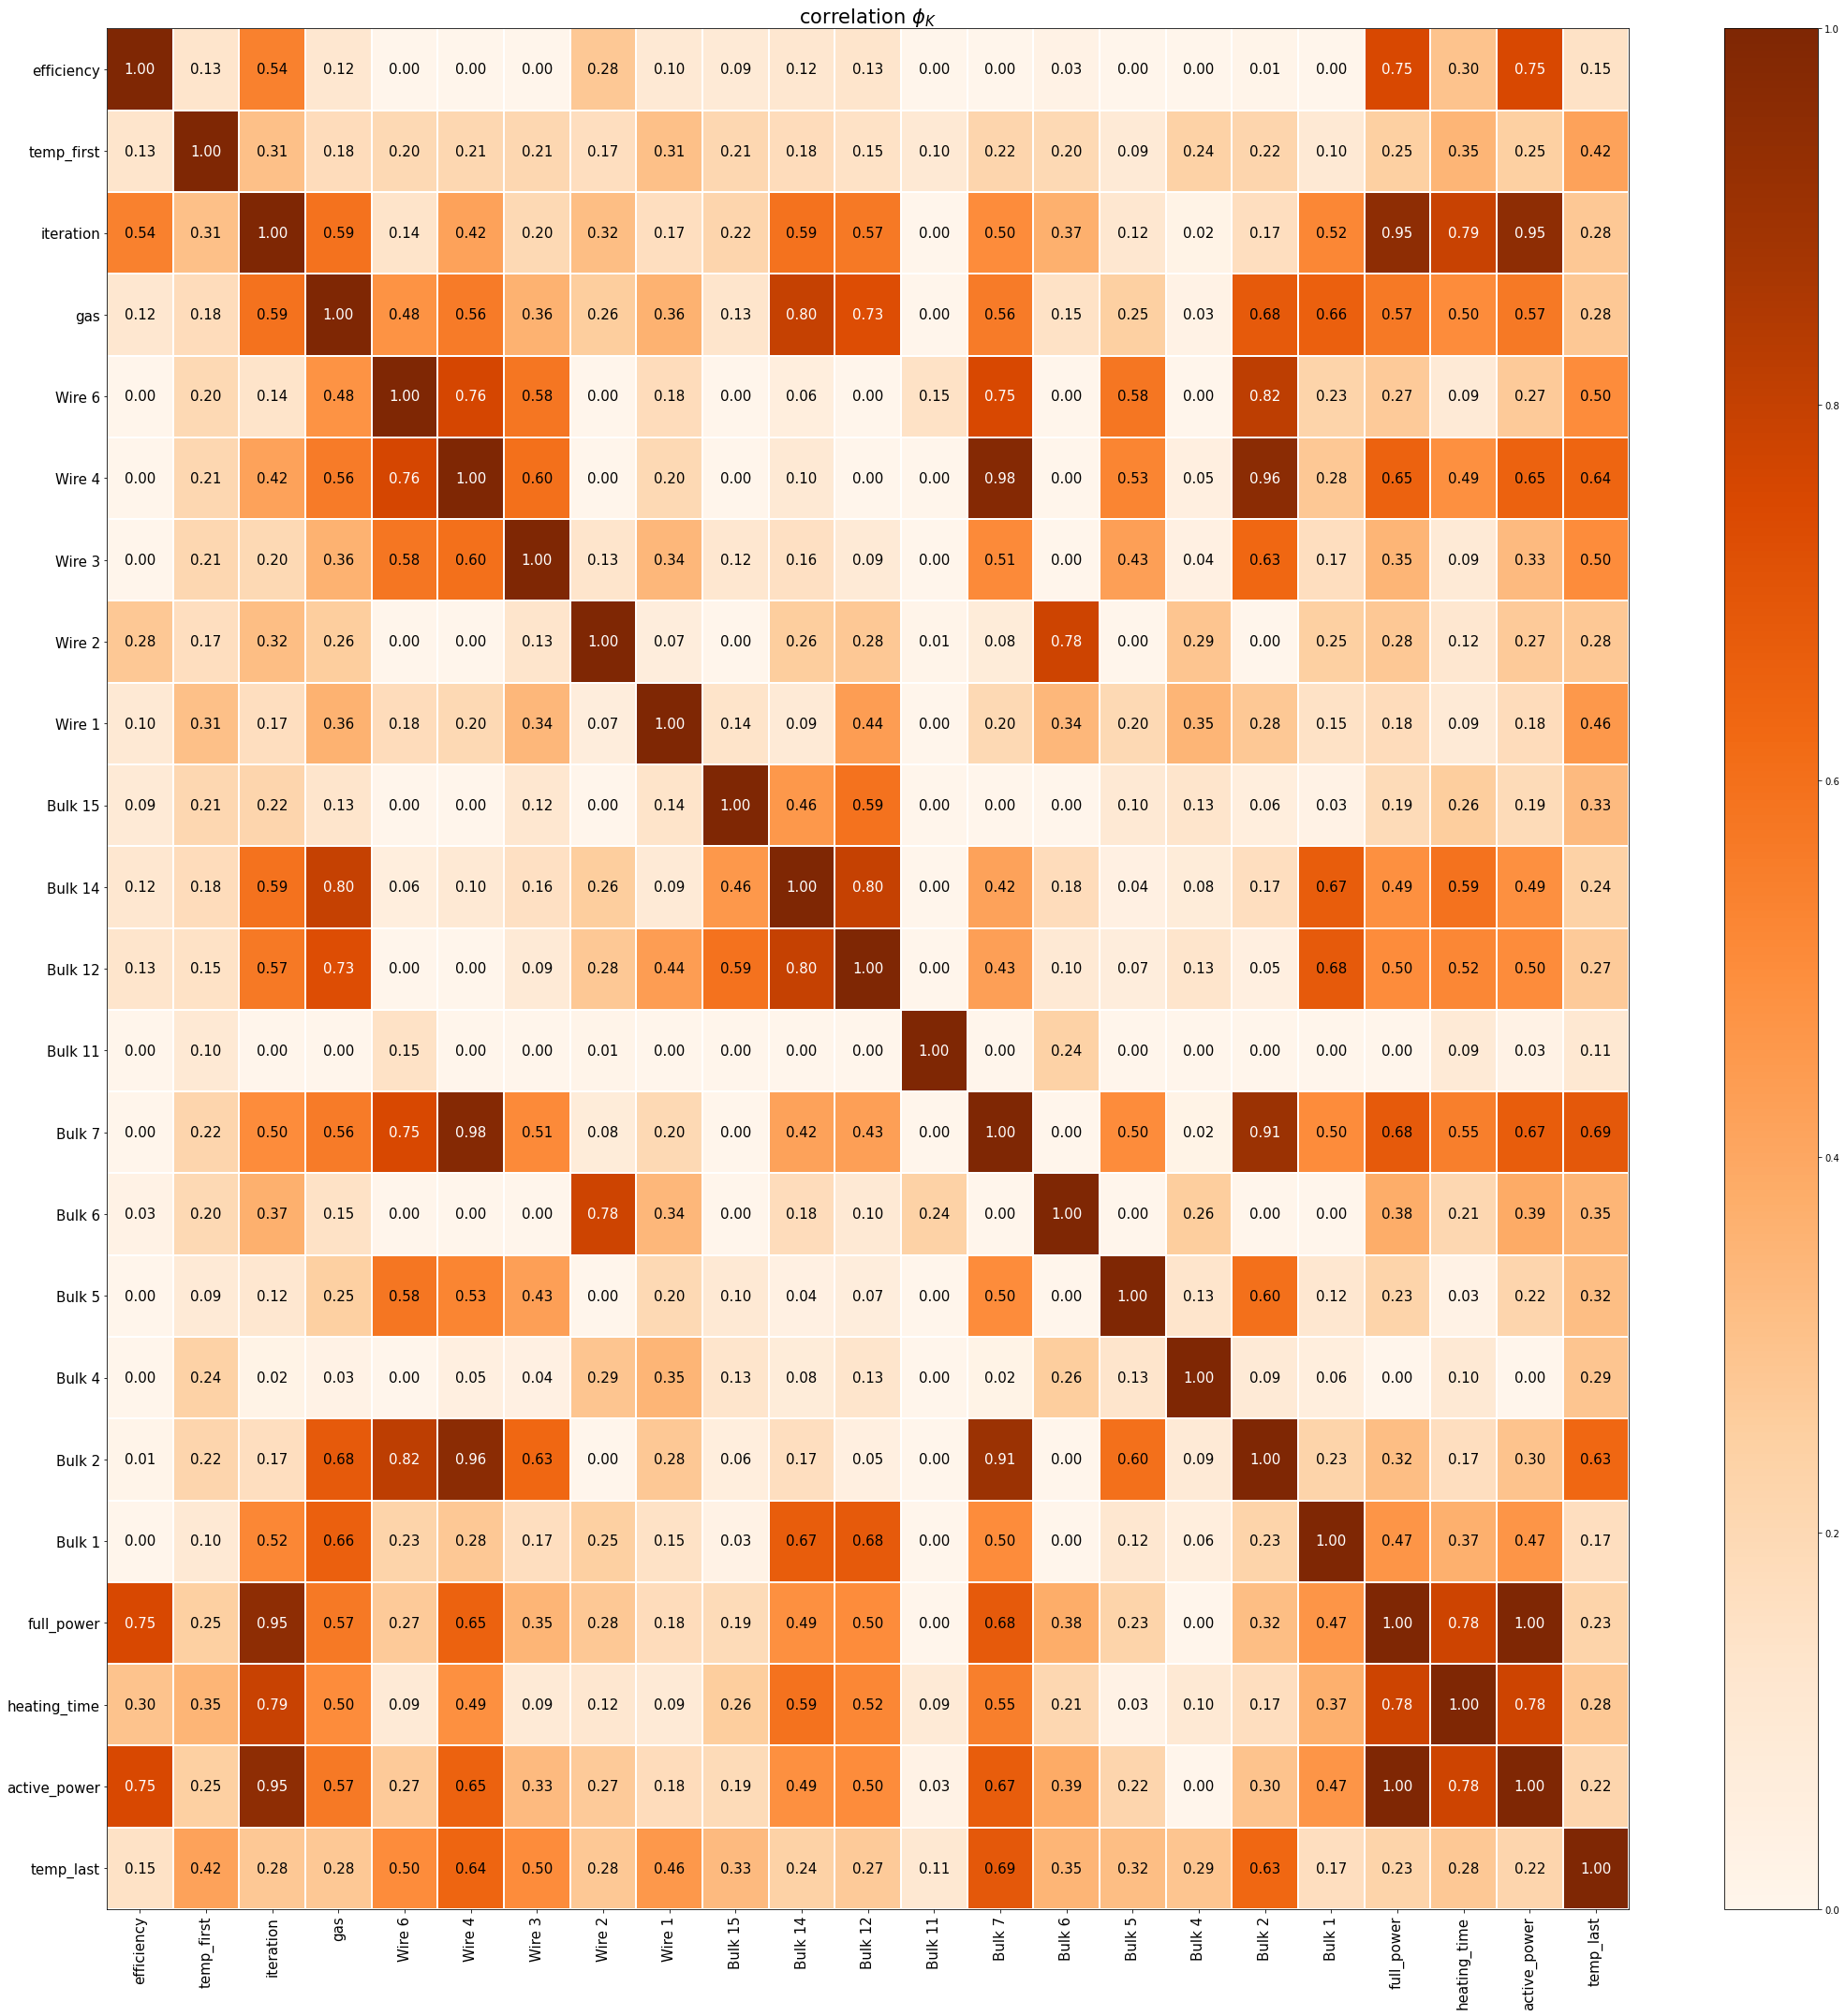

In [38]:
phik_overview = df_final.phik_matrix().round(2)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Oranges", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(30, 30))

Данные готовы для использования их в алгоритмах машинного обучения

## Построение и обучение моделей

### Подготовка данных для алгоритмов машинного обучения

In [39]:
features = df_final.drop(['temp_last'], axis=1)
target = df_final.temp_last

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

x_train.shape

(1743, 22)

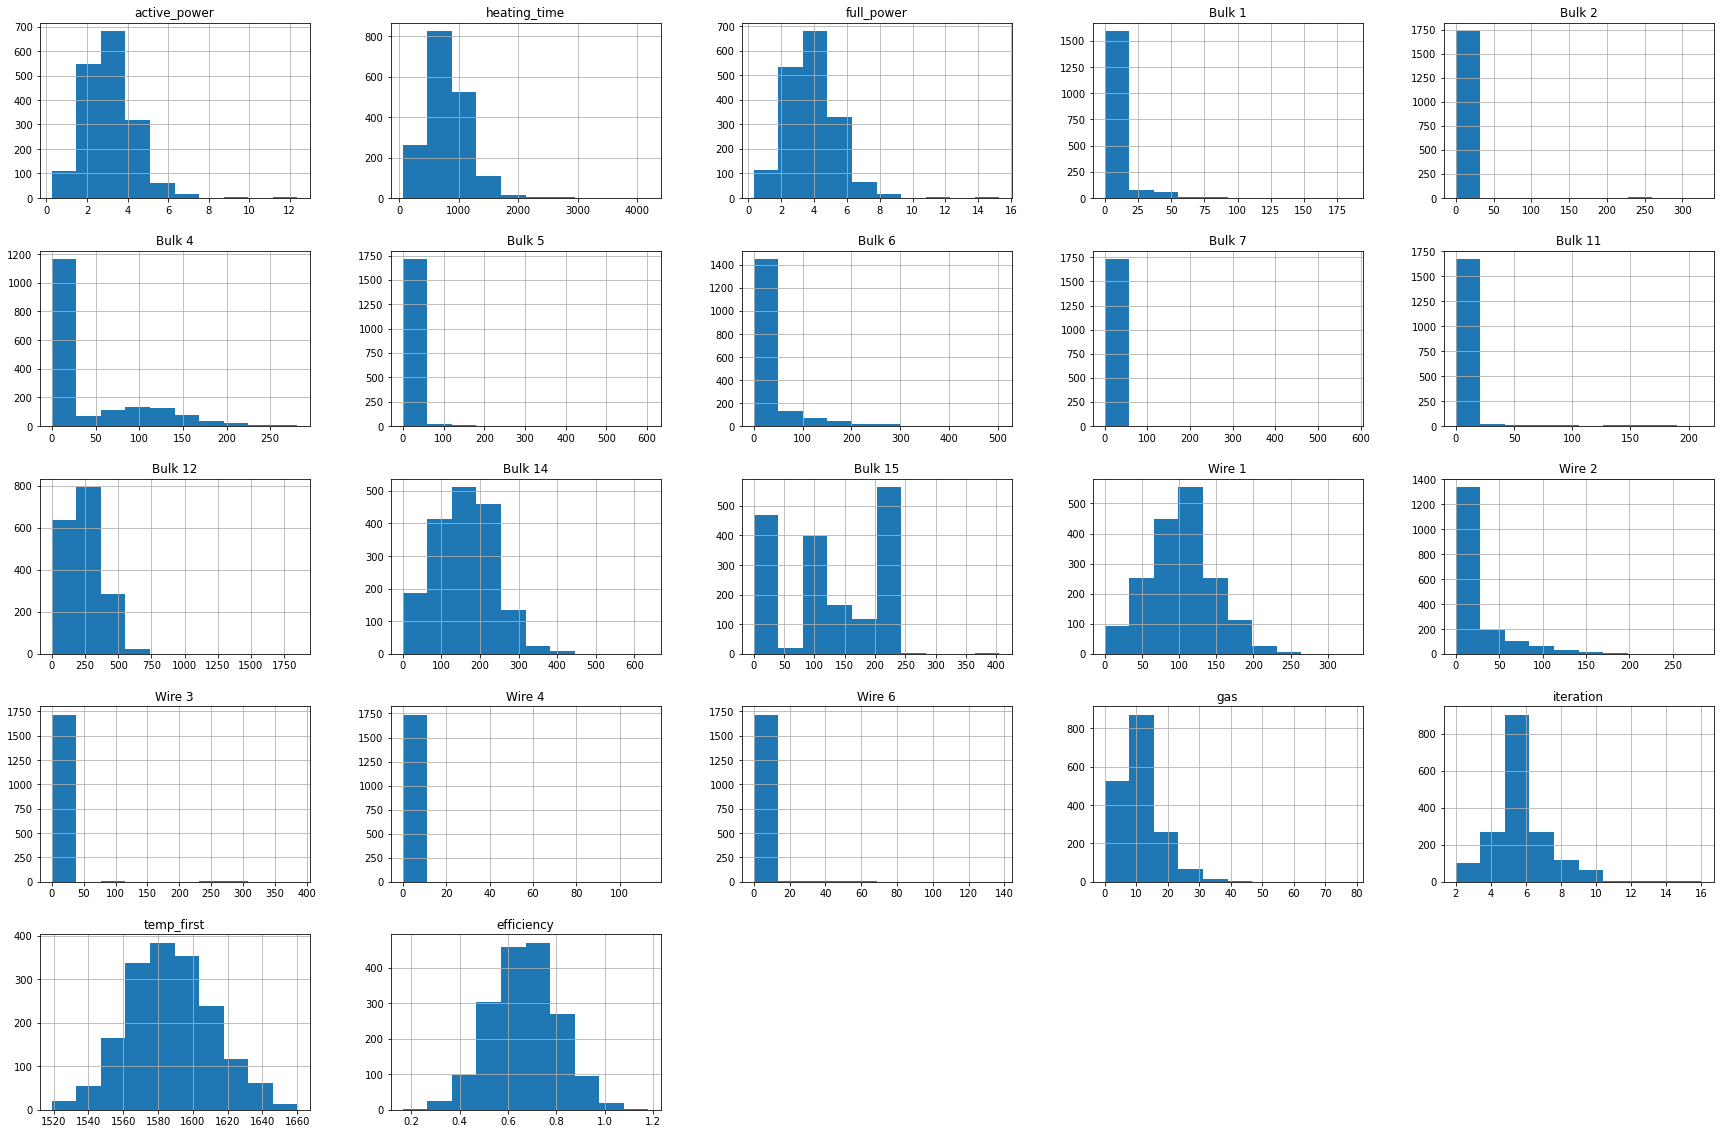

In [40]:
x_train.hist(figsize=(30, 20));

In [41]:
model = KNN(n_neighbors=3)

model.fit(x_train)
outliers_index = x_train[model.predict(x_train) == 1].index

x_train = x_train.drop(outliers_index)
y_train = y_train.drop(outliers_index)

print("Количество аномалий: ", len(outliers_index))
print("Размер x_train:", x_train.shape)

Количество аномалий:  131
Размер x_train: (1612, 22)


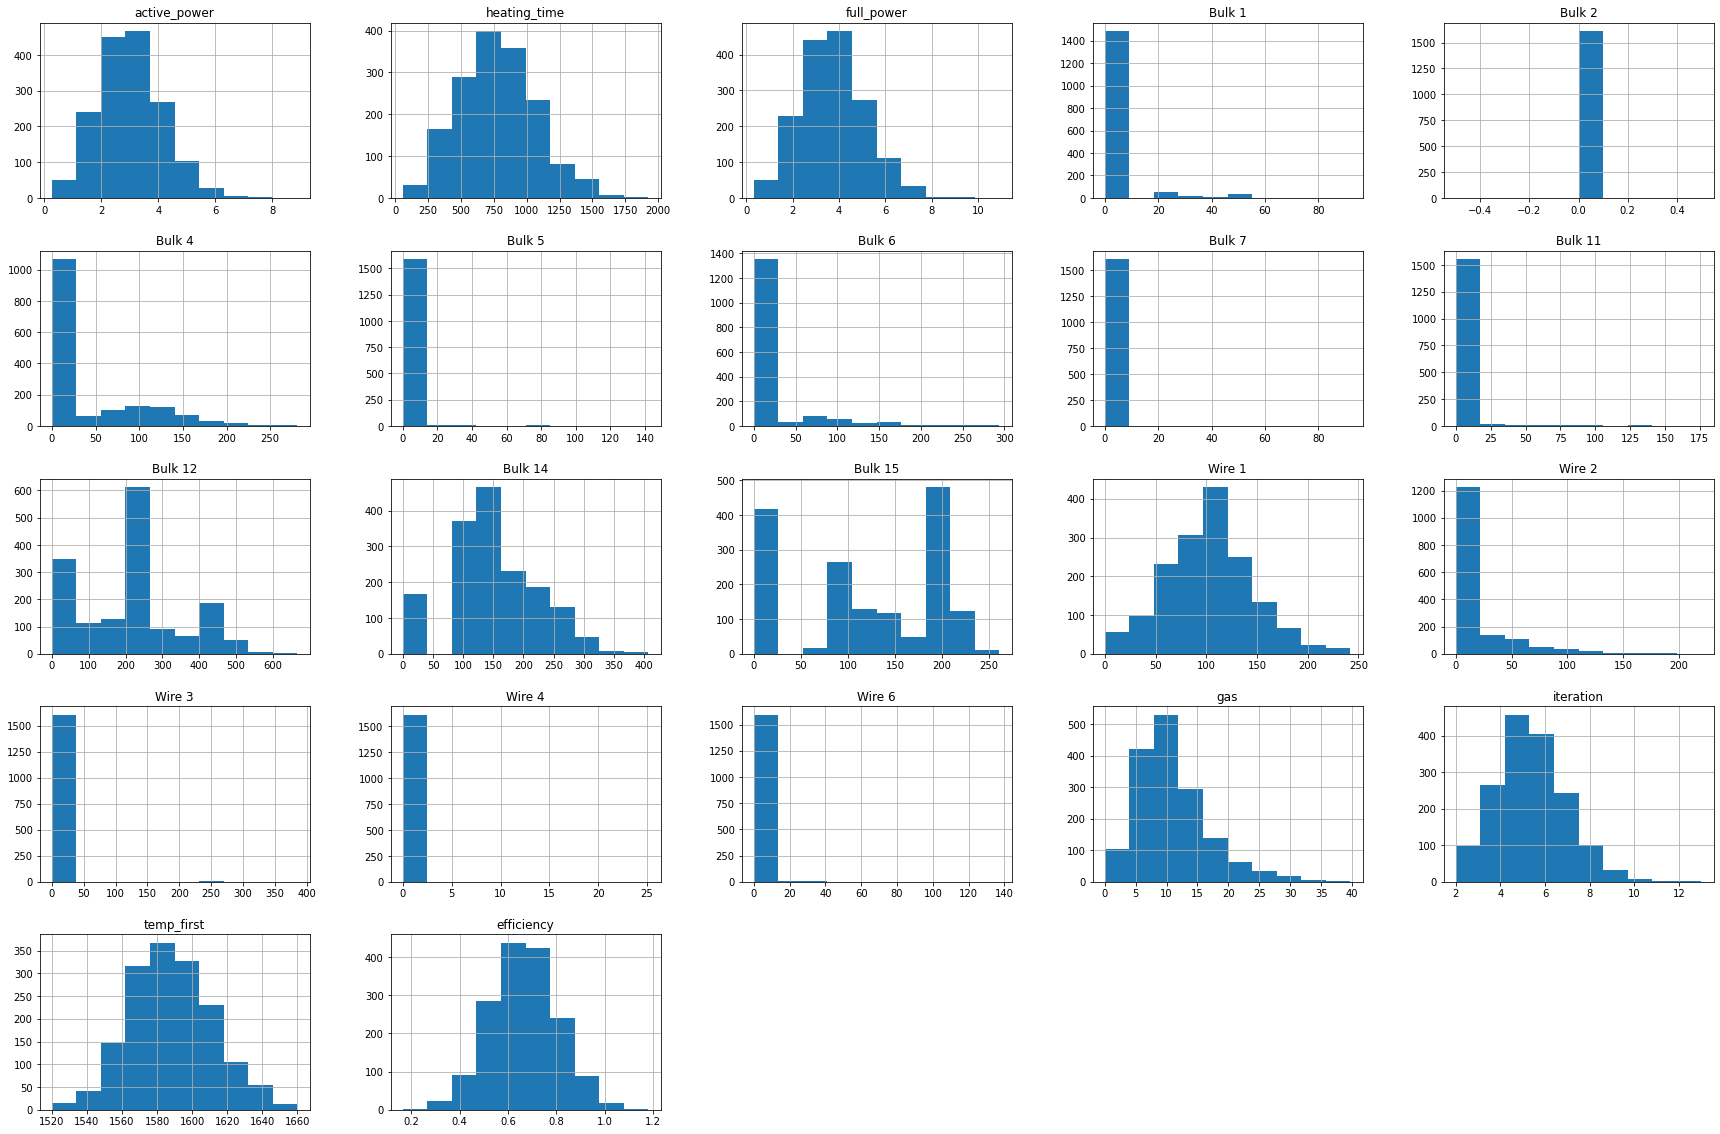

In [42]:
x_train.hist(figsize=(30, 20));

**Полученные результаты:**  
Разбил данные на 2 выборки тренировочная (75%) и тестовая (25%)  
Удалил часть выбросов с помощью метода KNN на тренировочной выборке
Так как все признаки числовые, то будем использовать алгоритмы машинного обучения - регрессия

### Алгоритм линейный - Ridge

In [43]:
%%time

scorer = make_scorer(mean_absolute_error, greater_is_better=False)

pipe_ridge = make_pipeline(StandardScaler(), Ridge(random_state=RANDOM_STATE))
abs(cross_val_score(pipe_ridge, x_train, y_train, scoring=scorer, cv=5).mean()).round(2)

CPU times: user 81.3 ms, sys: 178 ms, total: 259 ms
Wall time: 245 ms


5.93

In [44]:
pipe_ridge.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(random_state=170723))])

### Алгоритм ансамблей - RandomForestRegressor¶

In [45]:
%%time

parameters = {'n_estimators': range(100, 300, 50),
              'max_depth': range(3, 10, 3)}

model_rfr = RandomForestRegressor(random_state = RANDOM_STATE)

mae_rfr = RandomizedSearchCV(model_rfr, param_distributions=parameters, scoring=scorer, cv=5)
mae_rfr.fit(x_train, y_train)

CPU times: user 41.7 s, sys: 394 ms, total: 42.1 s
Wall time: 42.3 s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=170723),
                   param_distributions={'max_depth': range(3, 10, 3),
                                        'n_estimators': range(100, 300, 50)},
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [46]:
mae_rfr.best_params_, -mae_rfr.best_score_.round(2)

({'n_estimators': 150, 'max_depth': 9}, 5.98)

### Алгоритм градиентного бустинга - CatBoost

In [47]:
%%time

parameters = {'iterations': range(100, 300, 50),
              'depth': range(3, 10, 3),
}
model_cbr = CatBoostRegressor(random_state = RANDOM_STATE, verbose=False)

mae_cbr = RandomizedSearchCV(model_cbr, param_distributions=parameters, scoring=scorer, cv=5)
mae_cbr.fit(x_train, y_train)

CPU times: user 1min 13s, sys: 1.64 s, total: 1min 15s
Wall time: 1min 53s


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7febf8770cd0>,
                   param_distributions={'depth': range(3, 10, 3),
                                        'iterations': range(100, 300, 50)},
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [48]:
mae_cbr.best_params_, -mae_cbr.best_score_.round(2)

({'iterations': 250, 'depth': 3}, 5.87)

### Тестирование и анализ моделей

In [49]:
%%time

predictions_cbr = mae_cbr.predict(x_test)
mae = (mean_absolute_error(y_test, predictions_cbr)).round(2)
print('по моделе CatBoost лучший результат MAE на тестовой выборке =', mae)

по моделе CatBoost лучший результат MAE на тестовой выборке = 6.04
CPU times: user 3.54 ms, sys: 0 ns, total: 3.54 ms
Wall time: 3.04 ms


In [50]:
dummy_test = DummyRegressor(strategy="median")
dummy_test.fit(x_train, y_train)
dummy_test_pred = dummy_test.predict(x_test)
MAE_dummy = mean_absolute_error(y_test, dummy_test_pred).round(2)

print('на моделе DummyRegressor результат MAE =', MAE_dummy)

на моделе DummyRegressor результат MAE = 8.04


In [51]:
columns = x_train.columns.to_list()

features = pd.DataFrame({'CatBoost' : mae_cbr.best_estimator_.feature_importances_,
                         'Ridge' : pipe_ridge.named_steps['ridge'].coef_,
                         'RandomForestRegressor' : mae_rfr.best_estimator_.feature_importances_
                        },index=columns).sort_values(by='CatBoost')
features['RandomForestRegressor'] = (features['RandomForestRegressor'] / features['RandomForestRegressor'].sum())*100

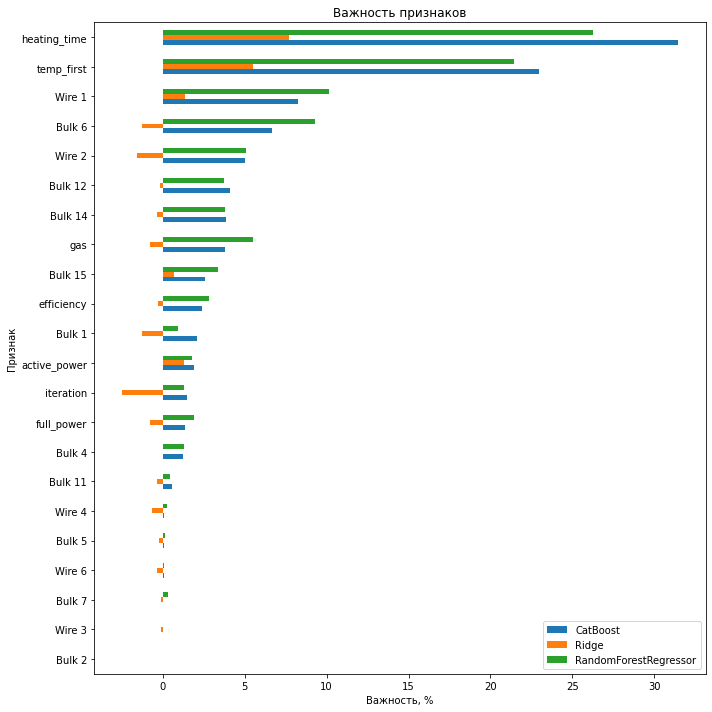

In [52]:
fig, ax = plt.subplots(figsize=(10,10))
features.plot.barh(ax=ax)
ax.set_title("Важность признаков")
ax.set_xlabel('Важность, %')
ax.set_ylabel('Признак')
fig.tight_layout()

## Отчет по проекту

Заказчик поставил задачу:  
«Построить модель, которая предскажет последнюю по времени температуру стали для каждой из партии, с целью уменьшения потребление электроэнергии на этапе обработки стали и снижения стоимости обслуживания и ремонта оборудования»

Для выполнения этой задачи была предварительно изучена предоставленная информация и составлен план работы, следуя которому необходимо было достигнуть конечного поставленного результата:  
«Создание рабочей модели, критерием которой является метрика MAE, не превышающая на тестовой выборке 6.8 (градусов)»

**Полученные результаты:**

*Так как лучшей моделью на валидации была модель с использованием **алгоритма градиентного бустинга – CatBoost**, то эта модель и использовалась на тестовой выборке*    
**полученная целевая метрика на тестовой выборке MAE = 6.04**  
*Данный результат существенно лучше заданного заказчиком критерия, что позволяет рекомендовать данную модель для использования поставленных задач*

Так же для оценки адекватности модели была построена константная модель  
Предсказания константной модели брались из расчета медианы значений последней по времени температур (целевого признака)  
полученная целевая метрика MAE константной модели = 8.04

Был проведен анализ важности факторов для всех трех алгоритмов  
Во всех трех алгоритмах наиболее важными признаками при обучении модели были:  
-время нагрева  
-начальная температура сплава

**Рекомендации по улучшению модели:** 
1.	Уменьшить  количество и разброс в измерениях температуры за счет эффективности контроля случаев, когда температура выходит за границы нормальности (проанализировав все факторы, которые на это могут повлиять: легирующие добавки, объем газа, качество электродов, качество работы сотрудников смены итд)
2.	Убрать все незначимые признаки, при котором кумулятивное накопление значимых признаков составляет не более 95% (использовать эти критерии при факторном анализе)
3.	Подобрать баланс между low variance (низкой дисперсией) и low bias (точностью предсказания), для решения поставленных задач отдать предпочтение в пользу low variance, путем определения диапазона колебания температуры и устойчивости модели к выбросам
